In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import warnings
from pmdarima import auto_arima
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense

warnings.filterwarnings("ignore")

In [ ]:
# Load synthetic data from CSV file
df = pd.read_csv("Synthetic_data_with_OEE_MME_16_06_24.csv")

# Convert 'Date' column to datetime if it's not already in datetime format
df["Date"] = pd.to_datetime(df["Date"])

In [ ]:
# Calculate MME (Machine Mechanical Efficiency)
df["MME"] = df["General_Running_Time"] / df["Effective_Running_Time"]

# Calculate OEE (Overall Equipment Effectiveness)
#df["Q"] = 1 - (df["Waste_Packages"] / (df["Waste_Packages"] + df["Good_Packages"]))  # Quality
#df["P"] = 1 - ((df["Nominal_Speed"] - df["Actual_Speed"]) / df["Nominal_Speed"])  # Performance
#df["A"] = 1 - ((df["Ancillary_Time"] + df["Internal_Downtime"] + df["External_Downtime"]) / df["Base_Working_Time"])# Availability
df["OEE"] = df["Q"] * df["P"] * df["A"]  # Q=Quality, P=Performance, A=Availability

In [ ]:
#------------------------------------------------------------------TCN----------------------------------------------------------------------------------

In [ ]:
# Normalize features
scaler = MinMaxScaler()
df[['Effective_Running_Time', 'General_Running_Time', 'Ancillary_Time', 'Internal_Downtime', 'External_Downtime', 'Waste_Packages', 'Good_Packages', 'Nominal_Speed', 'Actual_Speed']] = scaler.fit_transform(df[['Effective_Running_Time', 'General_Running_Time', 'Ancillary_Time', 'Internal_Downtime', 'External_Downtime', 'Waste_Packages', 'Good_Packages', 'Nominal_Speed', 'Actual_Speed']])

# Prepare data for training
X = df[['Effective_Running_Time', 'General_Running_Time', 'Ancillary_Time', 'Internal_Downtime', 'External_Downtime', 'Waste_Packages', 'Good_Packages', 'Nominal_Speed', 'Actual_Speed']].values
y = df[['MME', 'OEE']].values
dates = df['Date'].values  # Save dates for plotting

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Build the model
model = Sequential([
    Input(shape=(9,1)),  # Define the input shape using Input layer
    Conv1D(filters=64, kernel_size=2, activation='relu'),  # Adjust kernel_size to 2
    MaxPooling1D(pool_size=1),  # Pooling size adjusted for the small input
    Flatten(),
    Dense(50, activation='relu'),
    Dense(2)
])

In [ ]:
# Compile the model
model.compile(optimizer = "adam", loss = "mse")

# Reshape input data for Conv1D
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Predict on test set
y_pred = model.predict(X_test)

# Separate predictions for MME and OEE
y_pred_MME = y_pred[:, 0]  # First column for MME
y_pred_OEE = y_pred[:, 1]  # Second column for OEE

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4835 - val_loss: 0.1407
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0890 - val_loss: 0.0746
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0572 - val_loss: 0.0498
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0401 - val_loss: 0.0389
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0339 - val_loss: 0.0283
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_loss: 0.0203
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.0160
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_l

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE for MME
rmse_MME = mean_squared_error(y_test[:, 0], y_pred_MME, squared=False)
print("Root Mean Squared Error (RMSE) for MME:", rmse_MME)

# Calculate RMSE for OEE
rmse_OEE = mean_squared_error(y_test[:, 1], y_pred_OEE, squared=False)
print("Root Mean Squared Error (RMSE) for OEE:", rmse_OEE)

# Calculate MAE
mae_MME = mean_absolute_error(y_test[:, 0], y_pred_MME)
print("Mean Absolute Error (MAE) for MME:", mae_MME)

# Calculate MAE for OEE
mae_OEE = mean_absolute_error(y_test[:, 1], y_pred_OEE)
print("Mean Absolute Error (MAE) for OEE:", mae_OEE)

# Calculate MAPE for MME
mape_MME = mean_absolute_percentage_error(y_test[:, 0], y_pred_MME)
print("Mean Absolute Percentage Error (MAPE) for MME:", mape_MME, "%")

# Calculate MAPE for OEE
mape_OEE = mean_absolute_percentage_error(y_test[:, 1], y_pred_OEE)
print("Mean Absolute Percentage Error (MAPE) for OEE:", mape_OEE, "%")

Root Mean Squared Error (RMSE) for MME: 0.009323577758580564
Root Mean Squared Error (RMSE) for OEE: 0.00675212861780326
Mean Absolute Error (MAE) for MME: 0.007226867455389115
Mean Absolute Error (MAE) for OEE: 0.005502730844693906
Mean Absolute Percentage Error (MAPE) for MME: 0.5648269951267723 %
Mean Absolute Percentage Error (MAPE) for OEE: 0.8754250978219644 %


In [ ]:
#-----------------------------------------------------------ARIMA----------------------------------------------------------------------------------------

In [ ]:
# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [ ]:
# Function to check stationarity
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")

# Check stationarity and differencing if necessary
def make_stationary(series):
    check_stationarity(series)
    diff_order = 0
    while adfuller(series)[1] > 0.05:
        series = series.diff().dropna()
        diff_order += 1
    print(f'Series is stationary after differencing {diff_order} times')
    return series, diff_order

MME:
ADF Statistic: -15.574544786089096
p-value: 1.967445889114027e-28
Series is stationary
Series is stationary after differencing 0 times


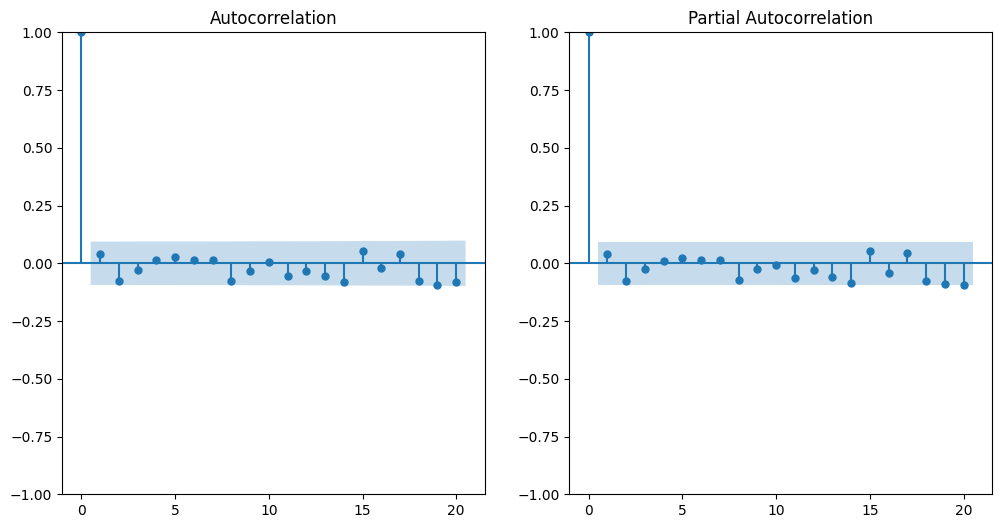

OEE:
ADF Statistic: -21.14162564622163
p-value: 0.0
Series is stationary
Series is stationary after differencing 0 times


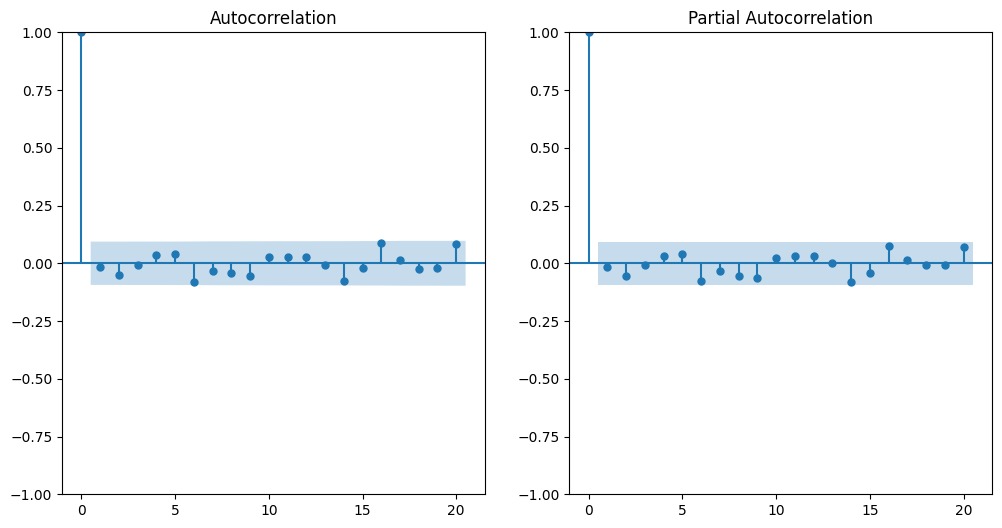

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1469.594, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=243.266, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1041.323, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=155.400, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-38.819, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-38.161, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-37.050, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-36.971, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-37.257, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-35.054, Time=0.25 sec


In [ ]:
# Function to plot ACF and PACF
def plot_acf_pacf(series):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, ax=plt.gca(), lags=20)
    plt.subplot(122)
    plot_pacf(series, ax=plt.gca(), lags=20)
    plt.show()

# Stationarity and ACF/PACF for MME
print("MME:")
mme_stationary, mme_diff_order = make_stationary(train['MME'])
plot_acf_pacf(mme_stationary)

# Stationarity and ACF/PACF for OEE
print("OEE:")
oee_stationary, oee_diff_order = make_stationary(train['OEE'])
plot_acf_pacf(oee_stationary)

# Auto ARIMA for MME
model_mme = auto_arima(train['MME'], seasonal=False, trace=True)
print(model_mme.summary())

# Auto ARIMA for OEE
model_oee = auto_arima(train['OEE'], seasonal=False, trace=True)
print(model_oee.summary())

In [ ]:
# Function to fit and predict using ARIMA with given orders
def arima_predict(train, test, target, order):
    history = [x for x in train[target]]
    predictions = []
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[target].iloc[t])
    return predictions

# Extract best orders from auto_arima
order_mme = model_mme.order
print(order_mme)
order_oee = model_oee.order
print(order_oee)

(2, 0, 0)
(0, 0, 0)


In [ ]:
# Predict MME and OEE using ARIMA
predictions_mme = arima_predict(train, test, 'MME', order_mme)
predictions_oee = arima_predict(train, test, 'OEE', order_oee)

In [ ]:
# RMSE_MME using ARIMA
rmse_mme = mean_squared_error(test['MME'], predictions_mme, squared=False)
print("Root Mean Squared Error (RMSE) for MME:", rmse_mme)

# RMSE_OEE using ARIMA
rmse_oee = mean_squared_error(test['OEE'], predictions_oee, squared=False)
print("Root Mean Squared Error (RMSE) for OEE:", rmse_oee)

Root Mean Squared Error (RMSE) for MME: 0.257866123004417
Root Mean Squared Error (RMSE) for OEE: 0.07479598860033315


In [ ]:
# Calculate MAE
mae_MME = mean_absolute_error(test['MME'], predictions_mme)
print("Mean Absolute Error (MAE) for MME:", mae_MME)

# Calculate MAE for OEE
mae_OEE = mean_absolute_error(test['OEE'], predictions_oee)
print("Mean Absolute Error (MAE) for OEE:", mae_OEE)

# Calculate MAPE for MME
mape_MME = mean_absolute_percentage_error(test['MME'], predictions_mme)
print("Mean Absolute Percentage Error (MAPE) for MME:", mape_MME, "%")

# Calculate MAPE for OEE
mape_OEE = mean_absolute_percentage_error(test['OEE'], predictions_oee)
print("Mean Absolute Percentage Error (MAPE) for OEE:", mape_OEE, "%")

Mean Absolute Error (MAE) for MME: 0.21340522260411876
Mean Absolute Error (MAE) for OEE: 0.06055933248710513
Mean Absolute Percentage Error (MAPE) for MME: 16.58815103311664 %
Mean Absolute Percentage Error (MAPE) for OEE: 9.711986578873114 %


In [ ]:
#-----------------------------------------------------TCN_plot----------------------------------------------------------------------------------

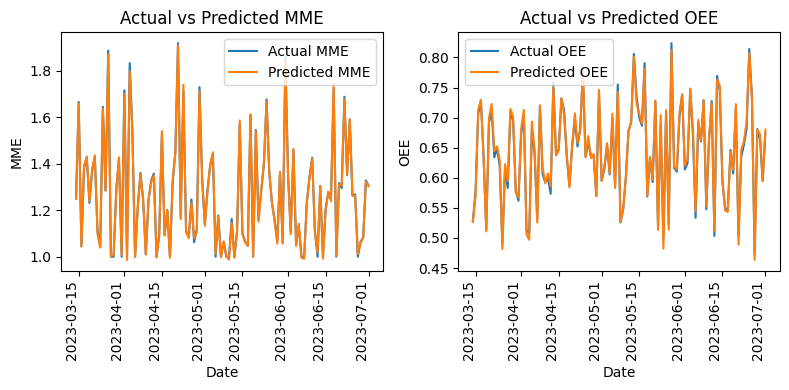

In [ ]:
# Plot Actual vs Predicted MME
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(dates[len(dates) - len(y_test):], y_test[:, 0], label='Actual MME')
plt.plot(dates[len(dates) - len(y_test):], y_pred_MME, label='Predicted MME')
plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.ylabel('MME')
plt.title('Actual vs Predicted MME')
plt.legend()

# Plot Actual vs Predicted OEE
plt.subplot(1, 2, 2)
plt.plot(dates[len(dates) - len(y_test):], y_test[:, 1], label='Actual OEE')
plt.plot(dates[len(dates) - len(y_test):], y_pred_OEE, label='Predicted OEE')
plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.ylabel('OEE')
plt.title('Actual vs Predicted OEE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
-----------------------------------------------------------------Arima_plot-----------------------------------------------------------------------------

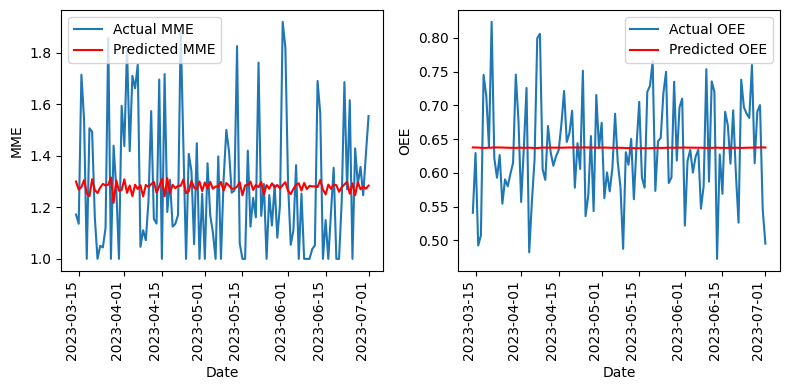

In [ ]:
# Plot predictions vs actuals
plt.figure(figsize=(8, 4))

# MME plot
plt.subplot(1, 2, 1)
plt.plot(test['Date'], test['MME'], label='Actual MME')
plt.plot(test['Date'], predictions_mme, color='red', label='Predicted MME')
plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.ylabel('MME')
plt.legend()

# OEE plot
plt.subplot(1, 2, 2)
plt.plot(test['Date'], test['OEE'], label='Actual OEE')
plt.plot(test['Date'], predictions_oee, color='red', label='Predicted OEE')
plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.ylabel('OEE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#---------------------------------------------------TCN_ARIMA_plot---------------------------------------------------------------------------------------

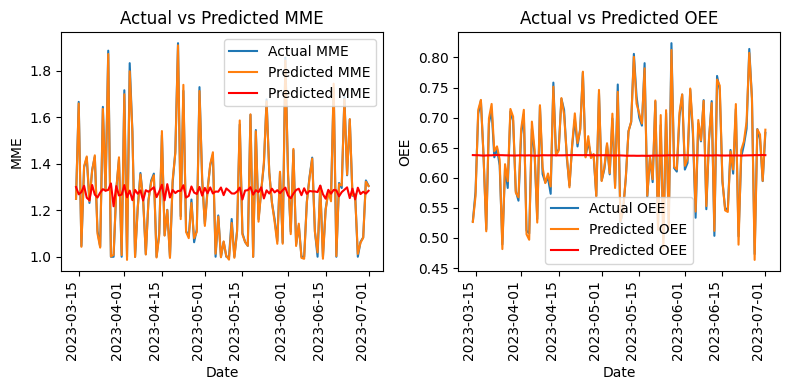

In [ ]:
# Plot Actual vs Predicted MME
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(dates[len(dates) - len(y_test):], y_test[:, 0], label='Actual MME')
plt.plot(dates[len(dates) - len(y_test):], y_pred_MME, label='Predicted MME')
plt.plot(test['Date'], predictions_mme, color='red', label='Predicted MME')
plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.ylabel('MME')
plt.title('Actual vs Predicted MME')
plt.legend()

# Plot Actual vs Predicted OEE
plt.subplot(1, 2, 2)
plt.plot(dates[len(dates) - len(y_test):], y_test[:, 1], label='Actual OEE')
plt.plot(dates[len(dates) - len(y_test):], y_pred_OEE, label='Predicted OEE')
plt.plot(test['Date'], predictions_oee, color='red', label='Predicted OEE')
plt.xlabel('Date')
plt.xticks(rotation=90, ha='right')
plt.ylabel('OEE')
plt.title('Actual vs Predicted OEE')
plt.legend()

plt.tight_layout()
plt.show()